In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [11]:
# sorts in-place
# easy to add custom predicate
def bubble_sort(arr):
    swapped_on_this_iteration = True
    sort_to_index = len(arr) - 1
    
    while swapped_on_this_iteration:
        swapped_on_this_iteration = False
        
        for i in range(sort_to_index):
            if arr[i] > arr[i + 1]:
                arr[i], arr[i + 1] = arr[i + 1], arr[i]
                swapped_on_this_iteration = True
        
        sort_to_index -= 1
    
    return arr

In [13]:
# trivial sorts
print(bubble_sort([]))
print(bubble_sort([123]))

# ordered
print(bubble_sort([1, 2, 3]))
# reverse ordered
print(bubble_sort([3, 2, 1]))

# other permutations
print(bubble_sort([1, 3, 2]))
print(bubble_sort([2, 1, 3]))
print(bubble_sort([2, 3, 1]))
print(bubble_sort([3, 1, 2]))

[]
[123]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]


In [20]:
df = pd.DataFrame(columns=("array_size", "time"));

# be careful with size, because time complexity is quadratic
sizes = np.arange(1, 1000)
number_of_trials = 10

for array_size in sizes:
    arr = np.arange(array_size)
    rng = np.random.default_rng()
    rng.shuffle(arr)
    
    for i in range(number_of_trials):
        start = timer()
        sorted_arr = bubble_sort(arr)
        end = timer()
        delta = end - start
        
        new_row = {
            "array_size": array_size,
            "time": delta
        }
        
        df.loc[len(df)] = new_row

df

,array_size,time
0,1,0.000006
1,1,0.000005
2,1,0.000005
3,1,0.000006
4,1,0.000004
...,...,...
9985,999,0.000556
9986,999,0.000562
9987,999,0.000391
9988,999,0.000246


<AxesSubplot:xlabel='array_size', ylabel='time'>

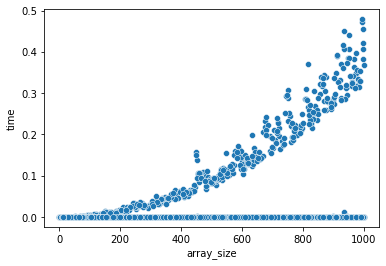

In [35]:
df_sample = df.sample(5000)
sns.scatterplot(data=df_sample, x="array_size", y="time")

Upper part looks clearly quadratic with small variation and minimal amount of outliers. It represents worst case scenarios - O(n^2)

<AxesSubplot:xlabel='array_size', ylabel='time'>

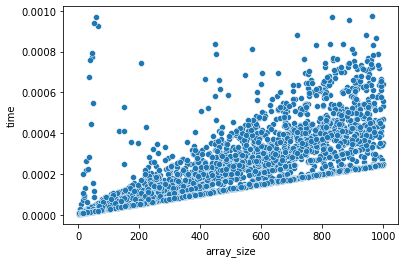

In [36]:
sns.scatterplot(data=df_sample[df_sample['time'] < 0.001], x="array_size", y="time")

Lower part of the plot is more interesting. It looks linear with variation increasing with array_size.

I'm also not sure why there are no values in between of two parts

In [43]:
df_mean_times = df.groupby('array_size', as_index=False).agg(mean_time=pd.NamedAgg(column="time", aggfunc="mean"))
df_mean_times

,array_size,mean_time
0,1,0.000006
1,2,0.000008
2,3,0.000006
3,4,0.000009
4,5,0.000010
...,...,...
994,995,0.041135
995,996,0.045642
996,997,0.042379
997,998,0.038481


<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

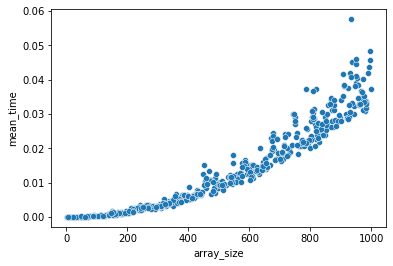

In [42]:
sns.scatterplot(data=df_mean_times.sample(500), x="array_size", y="mean_time")

Mean time also looks quadratic

Now i will try to estimate mean time with linear regression

In [47]:
df_regression = pd.DataFrame({
    'array_size': df_mean_times['array_size'],
    'array_size^2': df_mean_times['array_size']**2,
    'mean_time': df_mean_times['mean_time']
})
df_regression

,array_size,array_size^2,mean_time
0,1,1,0.000006
1,2,4,0.000008
2,3,9,0.000006
3,4,16,0.000009
4,5,25,0.000010
...,...,...,...
994,995,990025,0.041135
995,996,992016,0.045642
996,997,994009,0.042379
997,998,996004,0.038481


In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = df_regression[['array_size', 'array_size^2']]
y = df_regression['mean_time']

model.fit(X, y)

LinearRegression()

In [50]:
model.coef_

array([-3.12702090e-07,  3.94525251e-08])

In [56]:
regression_array_size = np.arange(1, 1000)
df_regression_predicted = pd.DataFrame({
    'array_size': regression_array_size,
    'array_size^2': regression_array_size**2
})

df_regression_predicted['mean_time'] = model.predict(df_regression_predicted)

<AxesSubplot:xlabel='array_size', ylabel='mean_time'>

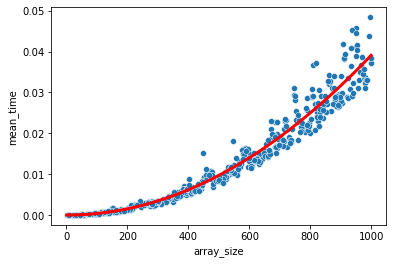

In [67]:
fig, ax = plt.subplots()

sns.scatterplot(ax=ax, data=df_mean_times.sample(500), x="array_size", y="mean_time")
sns.lineplot(ax=ax, data=df_regression_predicted, x="array_size", y="mean_time", color="red", linewidth = 3)

TODO: test number of steps distributions for different permutations of an array. This can explain large white gap between best and worst cases.

Also try to force best and worst cases manually (by selecting specific array permutation)